<a href="https://colab.research.google.com/github/HarshiniR4/Fall-2023-NYU-AI-hr2547/blob/main/Finals/Take_Home_Finals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Variational Autoencoder (VAE)
## HARSHINI RAJU

### 1. Imports and Setup
Import necessary libraries: optuna for hyperparameter optimization, tensorflow and its modules for building the neural network, numpy for numerical operations, matplotlib.pyplot for plotting, and os for filesystem operations.
python

In [ ]:
import optuna
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

### 2. Defining the VAE Training Function
The function `train_vae` is responsible for building and training the VAE (Variational Autoencoder) model. It takes in the `latent_dim` parameter along with other hyperparameters of the model. The function returns the training history, the encoder part of the VAE, a generator model (decoder) for generating images, and test data with labels.

This function is responsible for building a Variational Autoencoder (VAE) model. It does so by using an encoder network that takes in the input data and encodes it into a latent space. The encoder network consists of multiple layers of neural networks that are designed to learn and extract the most important features of the input data.

Once the input data is encoded into the latent space, a sampling function is applied to select points from the latent space. This is done to introduce stochasticity into the model, which helps in generating diverse outputs. The sampling function is designed to sample points from a probability distribution that is parameterized by the output of the encoder network.

Finally, the selected points are passed through a decoder network that decodes them back into the original data format. The decoder network also consists of multiple layers of neural networks that are designed to learn the inverse mapping of the encoder network. Together, the encoder and decoder networks form the VAE model, which can be trained using a variety of optimization techniques to minimize the reconstruction error.

The model is compiled and trained using the MNIST data.

In [ ]:
def train_vae(latent_dim, original_dim=28*28, intermediate_dim=64, batch_size=100, epochs=50, epsilon_std=1.0):
    # Encoder network
    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Sampling function
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decoder network
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # VAE model
    vae = Model(x, x_decoded_mean)

    # Loss calculation
    xent_loss = original_dim * tf.keras.losses.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    # Data preprocessing
    (x_train, _), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((x_train.shape[0], original_dim))
    x_test = x_test.reshape((x_test.shape[0], original_dim))

    # Training the model
    history = vae.fit(x_train,
                      shuffle=True,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_data=(x_test, None))  # No target data

    # Building the encoder and decoder models for visualization and generation
    encoder = Model(x, z_mean)
    decoder_input = Input(shape=(latent_dim,))
    _h_decoded = decoder_h(decoder_input)
    _x_decoded_mean = decoder_mean(_h_decoded)
    generator = Model(decoder_input, _x_decoded_mean)

    return history, encoder, generator, x_test, y_test

### 3. Objective Function for Optuna
This function is at the core of the hyperparameter optimization process with Optuna. It receives a trial object from Optuna that suggests a value for latent_dim. The function then calls train_vae with the suggested latent_dim, plots the training and validation loss curves, and visualizes the latent space. Besides, it generates images for digits 0-9 using the VAE and saves these images in a local directory. Finally, the function returns the last validation loss, which Optuna attempts to minimize.

### 4. Optuna Study for Hyperparameter Optimization
An Optuna study is created with the objective to minimize the returned value (validation loss) from the objective function.
study.optimize runs the optimization process for a specified number of trials (n_trials=10).

### 5. Image Generation and Saving
In each trial, after training, the function generates images corresponding to random points in the latent space using the decoder (generator) part of the VAE.
These images are displayed in a Matplotlib figure and saved to a directory named vae_generated_images. The filename indicates the trial number and the latent dimension.

### 6. Directory Management and Plot Saving
os.makedirs ensures that the directory for saving images exists (exist_ok=True allows the code to proceed without error if the directory already exists).
plt.savefig saves the generated images to the specified directory.
plt.close closes the figure after saving to free up memory.

In [ ]:
def objective(trial):
    # Suggest a value for the latent dimension
    latent_dim = trial.suggest_int('latent_dim', 1, 20)

    history, encoder, generator, x_test, y_test = train_vae(latent_dim)
    # ... [Plotting code for loss and latent space] ...

    # Plotting the loss curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title(f'Training and validation loss for latent dim {latent_dim}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"loss_curve_trial_{trial.number}_latent_dim_{latent_dim}.png")
    plt.show()

    # Displaying a 2D plot of the digit classes in the latent space
    x_test_encoded = encoder.predict(x_test)
    plt.figure(figsize=(6, 6))
    if latent_dim == 1:
        plt.scatter(x_test_encoded, np.zeros_like(x_test_encoded), c=y_test, cmap='viridis')
    else:
        plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
    plt.colorbar()
    plt.title(f'Latent space for latent dim {latent_dim}')
    plt.xlabel('z_1')
    if latent_dim != 1:
        plt.ylabel('z_2')
    plt.savefig(f"latent_space_trial_{trial.number}_latent_dim_{latent_dim}.png")
    plt.show()

    # Generate and display VAE images for all digits 0-9
    n = 10  # 10 digits
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Sample from the latent space and generate an image
        z_sample = np.random.normal(size=(1, latent_dim))
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(28, 28)

        plt.subplot(1, n, i + 1)
        plt.imshow(digit, cmap='gray')
        plt.axis('off')

     # Create a directory to save images if it doesn't exist
    os.makedirs("vae_generated_images", exist_ok=True)
    plt.savefig(f"vae_generated_images/vae_digits_trial_{trial.number}_latent_dim_{latent_dim}.png")
    plt.show()
    plt.close()

    return history.history['val_loss'][-1]

[I 2023-12-21 22:35:46,054] A new study created in memory with name: no-name-6deb20f8-850d-4743-949b-854c05ed02e7


Epoch 1/50
600/600 [==============================] - 4s 5ms/step - loss: 179.6218 - val_loss: 145.9733
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 139.3934 - val_loss: 132.9622
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 130.6332 - val_loss: 126.5426
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 126.5331 - val_loss: 124.3289
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 124.2541 - val_loss: 122.5499
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 122.6646 - val_loss: 120.6593
Epoch 7/50
600/600 [==============================] - 3s 6ms/step - loss: 121.5131 - val_loss: 119.4317
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 120.6298 - val_loss: 119.1732
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 119.9233 - val_loss: 118.2402
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

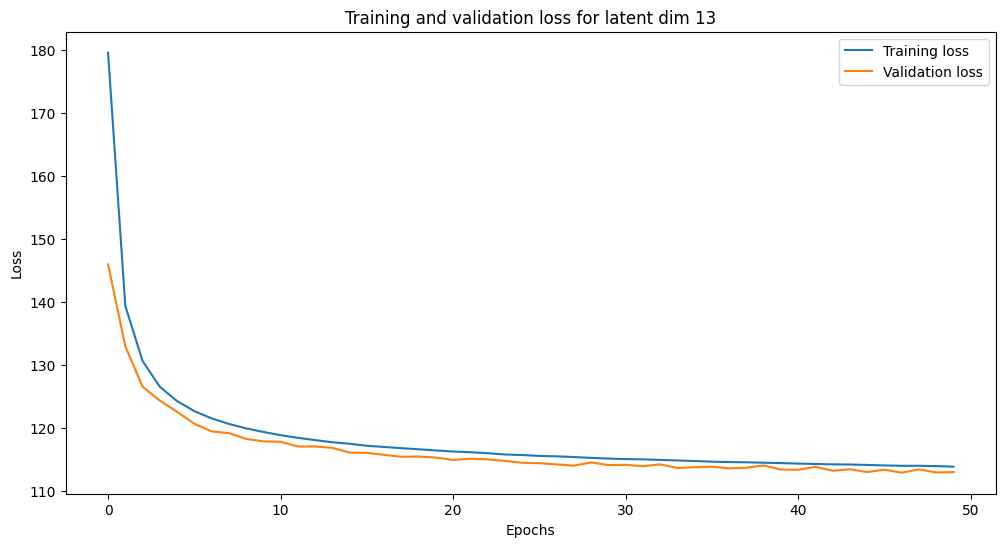

313/313 [==============================] - 1s 2ms/step


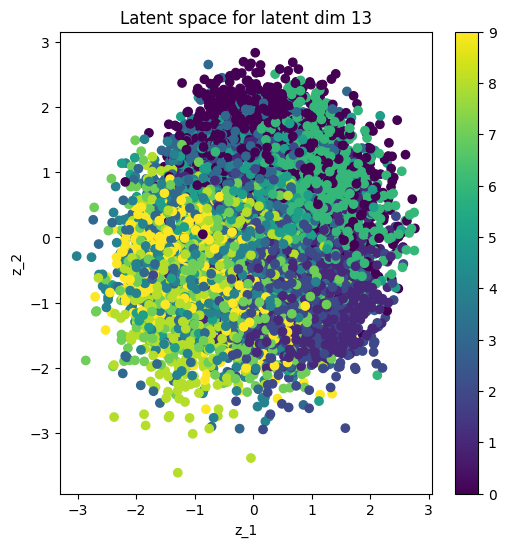

1/1 [==============================] - 0s 21ms/step


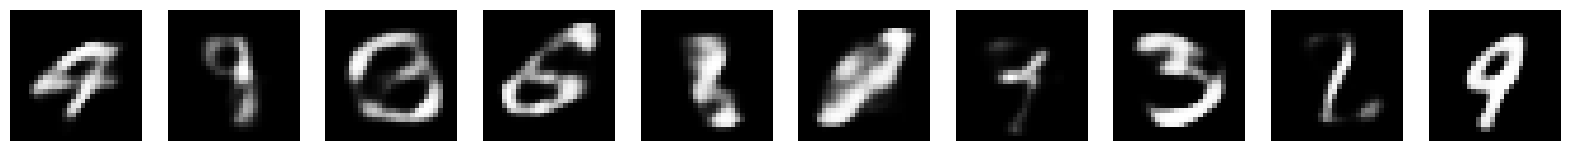

[I 2023-12-21 22:38:18,363] Trial 0 finished with value: 112.96569061279297 and parameters: {'latent_dim': 13}. Best is trial 0 with value: 112.96569061279297.


Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 178.0646 - val_loss: 145.1756
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 138.8155 - val_loss: 131.7443
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 129.8824 - val_loss: 126.0455
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 125.5090 - val_loss: 122.7742
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 123.0104 - val_loss: 120.2492
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 121.4127 - val_loss: 119.1355
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 120.2200 - val_loss: 119.1342
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 119.3418 - val_loss: 117.5941
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 118.5884 - val_loss: 116.9162
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

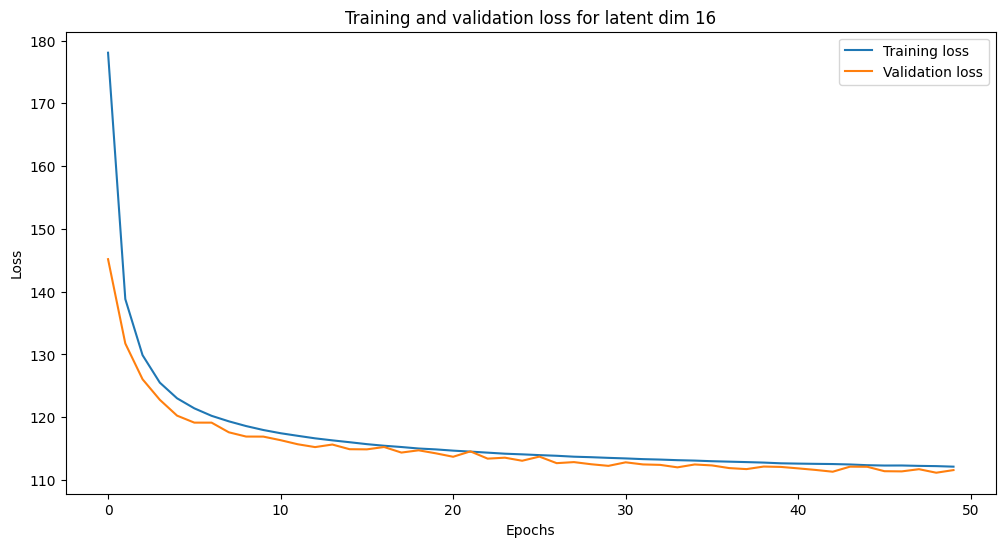

313/313 [==============================] - 1s 2ms/step


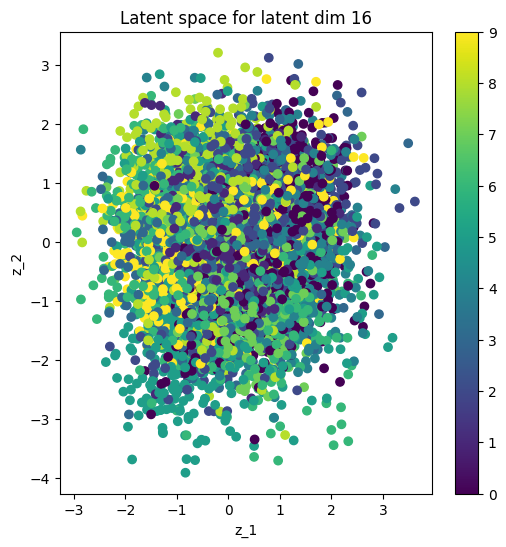

1/1 [==============================] - 0s 19ms/step


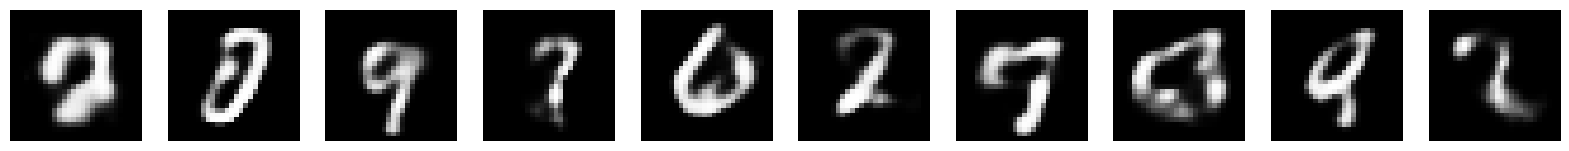

[I 2023-12-21 22:41:44,329] Trial 1 finished with value: 111.5752182006836 and parameters: {'latent_dim': 16}. Best is trial 1 with value: 111.5752182006836.


Epoch 1/50
600/600 [==============================] - 4s 5ms/step - loss: 180.3319 - val_loss: 144.1629
Epoch 2/50
600/600 [==============================] - 4s 6ms/step - loss: 138.6439 - val_loss: 134.2827
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 131.4065 - val_loss: 128.2015
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 128.0455 - val_loss: 125.7080
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 126.0010 - val_loss: 123.9885
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 124.5999 - val_loss: 123.0173
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 123.4816 - val_loss: 122.6924
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 122.6165 - val_loss: 120.9796
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 121.9139 - val_loss: 121.5103
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

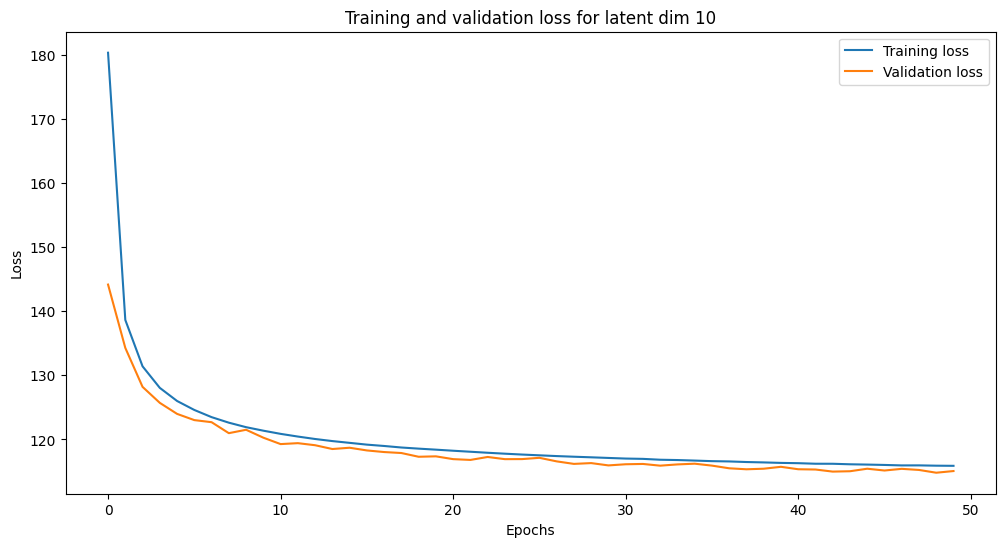

313/313 [==============================] - 1s 2ms/step


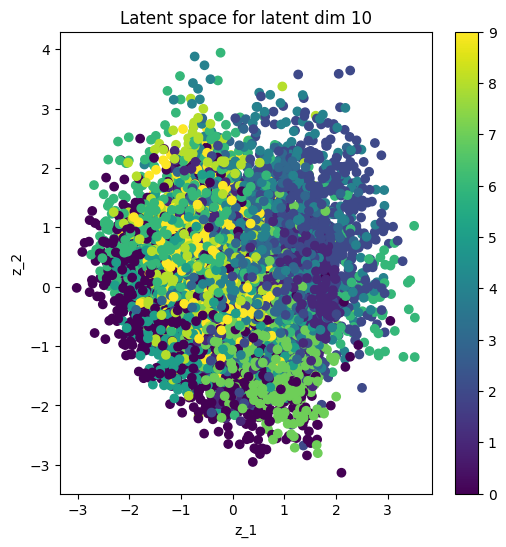

1/1 [==============================] - 0s 17ms/step


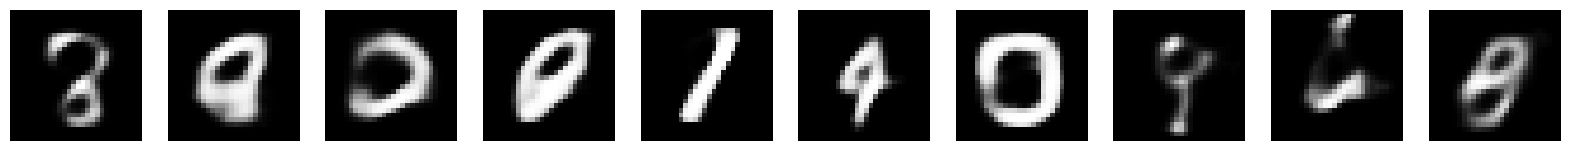

[I 2023-12-21 22:44:23,670] Trial 2 finished with value: 115.06978607177734 and parameters: {'latent_dim': 10}. Best is trial 1 with value: 111.5752182006836.


Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 196.8123 - val_loss: 168.0449
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 163.3267 - val_loss: 159.4451
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 157.9207 - val_loss: 156.1834
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 155.5200 - val_loss: 154.7760
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 153.9485 - val_loss: 153.0172
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 152.8344 - val_loss: 152.6586
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 151.8773 - val_loss: 151.3584
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 151.0121 - val_loss: 150.6851
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 150.2297 - val_loss: 150.0841
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

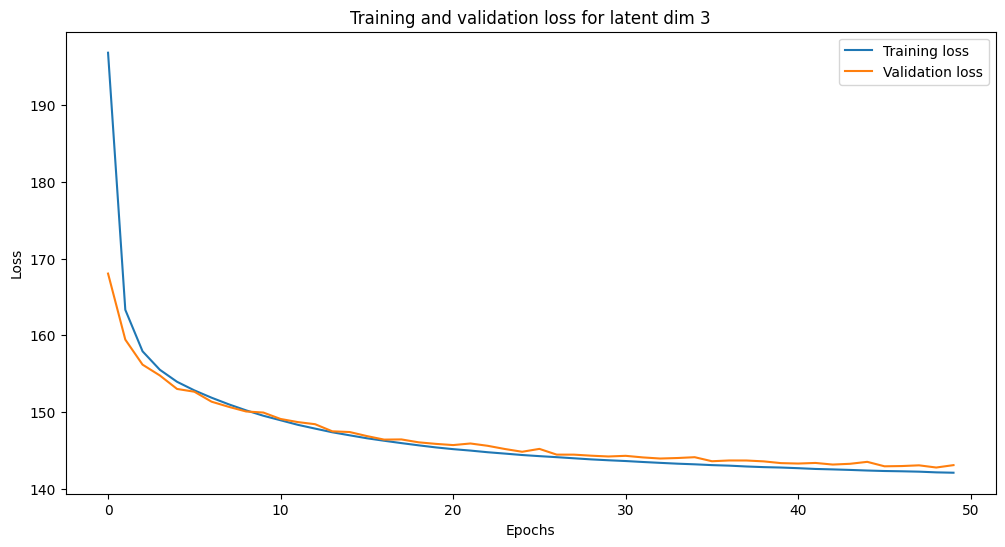

313/313 [==============================] - 1s 1ms/step


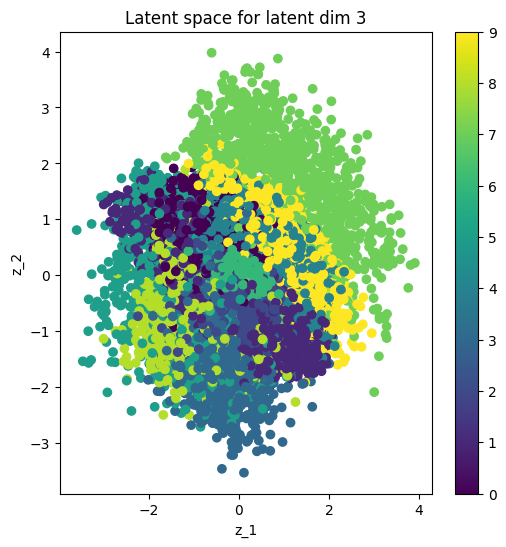

1/1 [==============================] - 0s 19ms/step


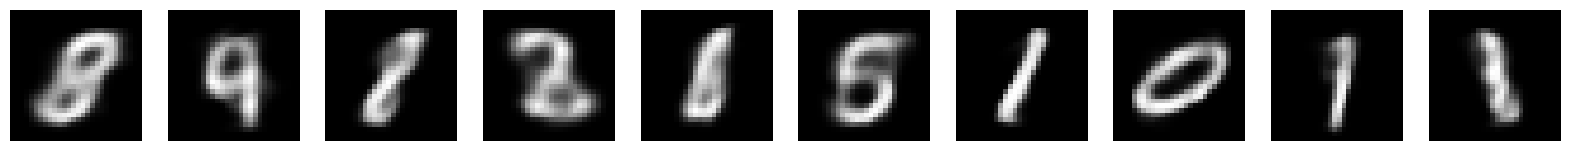

[I 2023-12-21 22:47:05,532] Trial 3 finished with value: 143.0953369140625 and parameters: {'latent_dim': 3}. Best is trial 1 with value: 111.5752182006836.


Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 179.4773 - val_loss: 146.7093
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 139.8433 - val_loss: 133.3502
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 130.5620 - val_loss: 126.6601
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 126.3423 - val_loss: 124.9415
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 123.6109 - val_loss: 121.3289
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 121.5129 - val_loss: 119.3815
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 120.1670 - val_loss: 118.3583
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 119.2440 - val_loss: 117.3141
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 118.4994 - val_loss: 117.8903
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

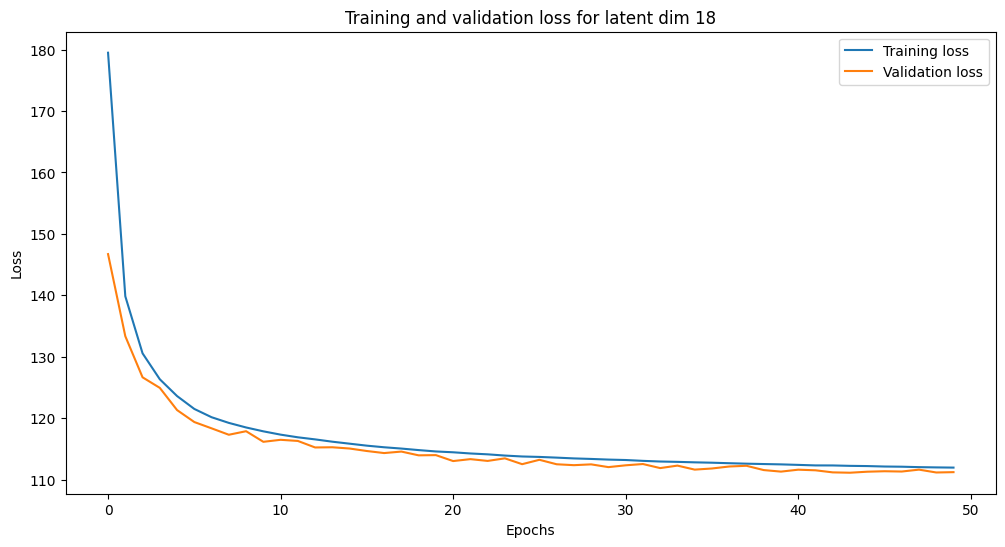

313/313 [==============================] - 1s 2ms/step


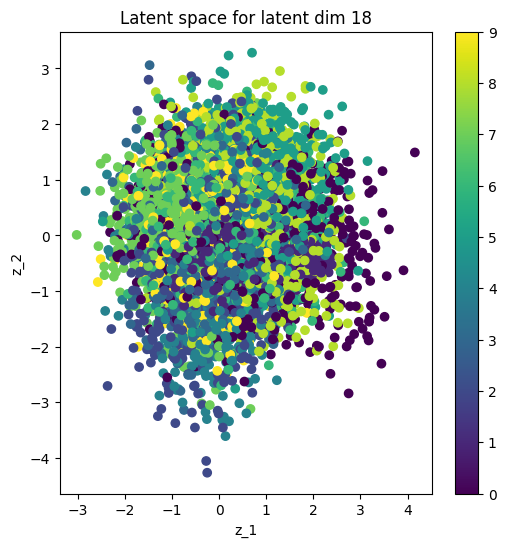

1/1 [==============================] - 0s 19ms/step


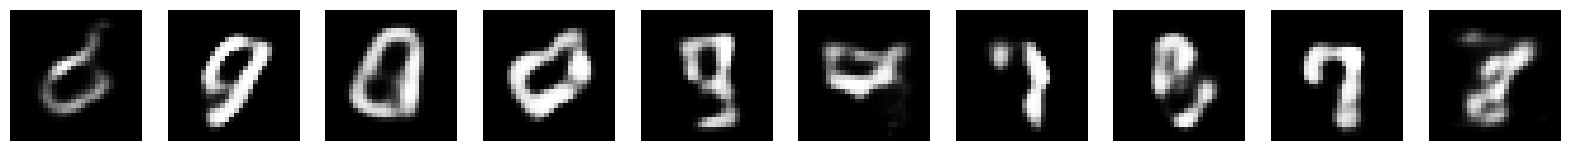

[I 2023-12-21 22:50:31,552] Trial 4 finished with value: 111.22822570800781 and parameters: {'latent_dim': 18}. Best is trial 4 with value: 111.22822570800781.


Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 179.7580 - val_loss: 145.7470
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 139.7986 - val_loss: 133.1359
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 130.6502 - val_loss: 126.4558
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 126.0212 - val_loss: 124.4753
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 123.4049 - val_loss: 120.7208
Epoch 6/50
600/600 [==============================] - 3s 6ms/step - loss: 121.6396 - val_loss: 120.1480
Epoch 7/50
600/600 [==============================] - 3s 6ms/step - loss: 120.3983 - val_loss: 119.2953
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 119.4597 - val_loss: 118.0172
Epoch 9/50
600/600 [==============================] - 4s 6ms/step - loss: 118.7408 - val_loss: 117.7138
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

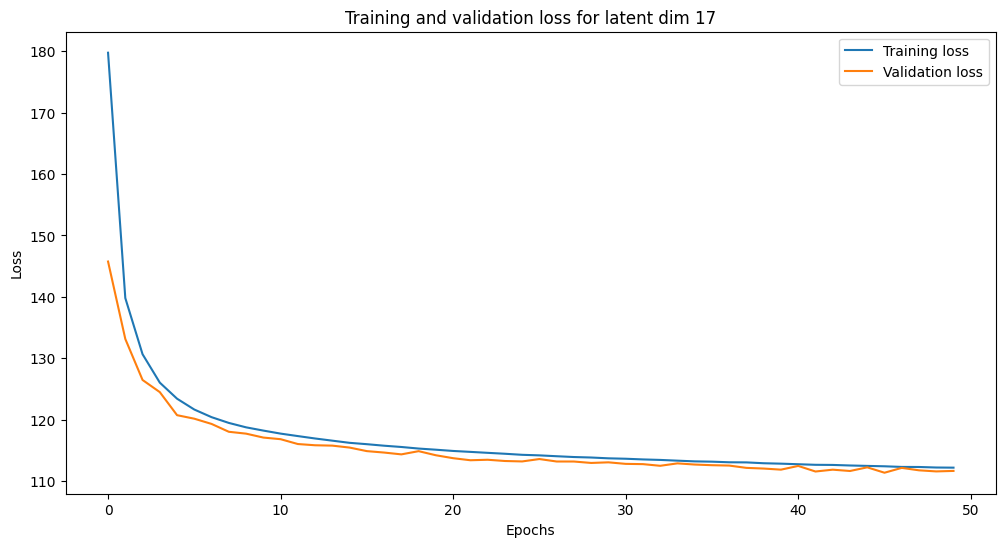

313/313 [==============================] - 1s 2ms/step


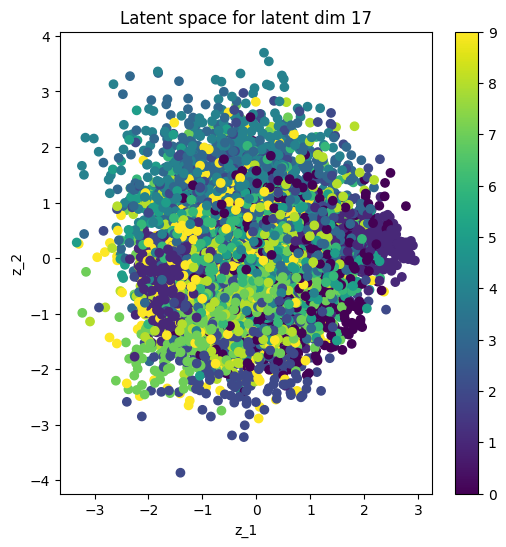

1/1 [==============================] - 0s 18ms/step


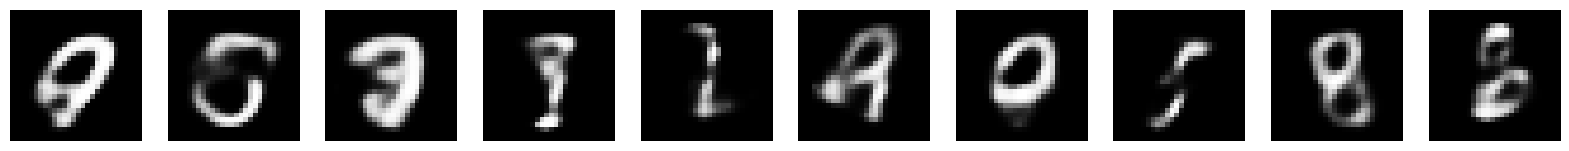

[I 2023-12-21 22:53:26,446] Trial 5 finished with value: 111.64199829101562 and parameters: {'latent_dim': 17}. Best is trial 4 with value: 111.22822570800781.


Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 179.9802 - val_loss: 147.4871
Epoch 2/50
600/600 [==============================] - 3s 6ms/step - loss: 142.5697 - val_loss: 137.3272
Epoch 3/50
600/600 [==============================] - 3s 6ms/step - loss: 135.0901 - val_loss: 131.5660
Epoch 4/50
600/600 [==============================] - 3s 6ms/step - loss: 131.1367 - val_loss: 129.2907
Epoch 5/50
600/600 [==============================] - 3s 6ms/step - loss: 128.8305 - val_loss: 126.9990
Epoch 6/50
600/600 [==============================] - 3s 6ms/step - loss: 127.3787 - val_loss: 125.4521
Epoch 7/50
600/600 [==============================] - 3s 6ms/step - loss: 126.3422 - val_loss: 125.3875
Epoch 8/50
600/600 [==============================] - 3s 6ms/step - loss: 125.5731 - val_loss: 124.9419
Epoch 9/50
600/600 [==============================] - 4s 6ms/step - loss: 124.9579 - val_loss: 123.7406
Epoch 10/50
600/600 [==============================] - 4s 7ms/st

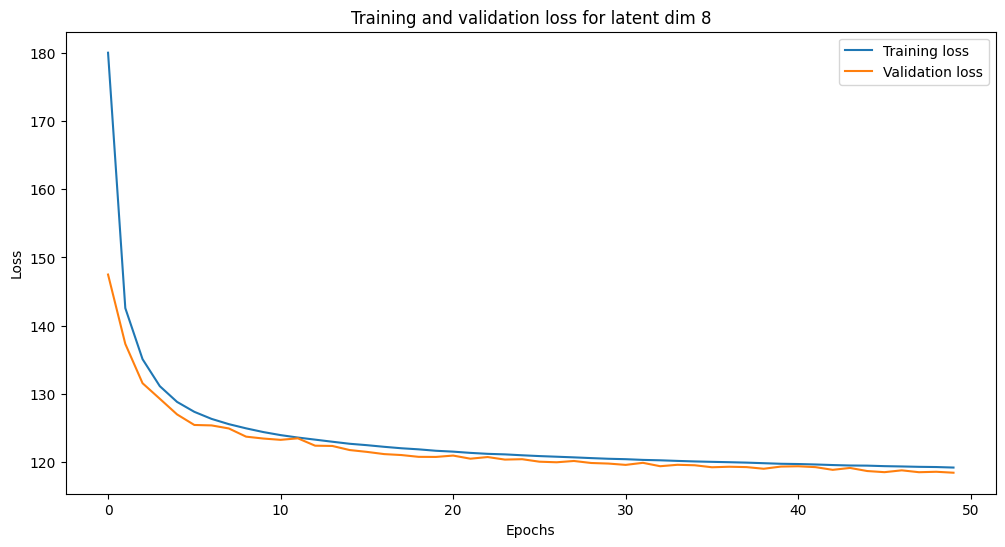

313/313 [==============================] - 1s 2ms/step


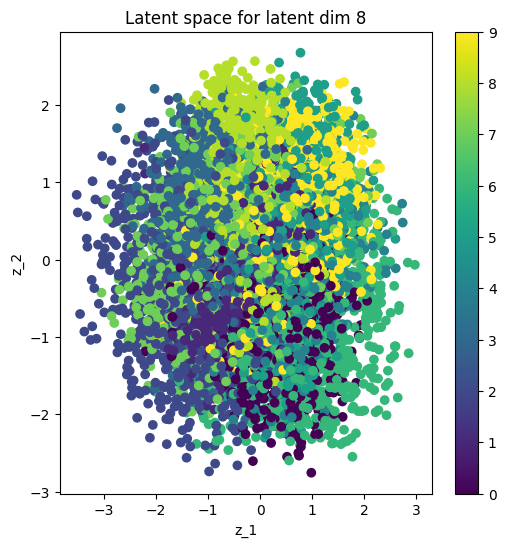

1/1 [==============================] - 0s 19ms/step


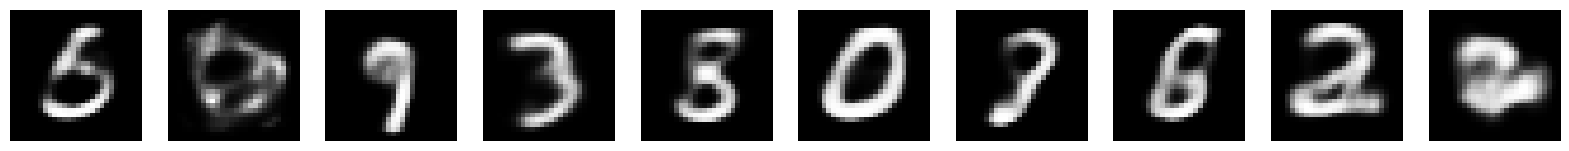

[I 2023-12-21 22:56:31,251] Trial 6 finished with value: 118.45759582519531 and parameters: {'latent_dim': 8}. Best is trial 4 with value: 111.22822570800781.


Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 181.5978 - val_loss: 148.1889
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 140.7427 - val_loss: 135.6247
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 131.7723 - val_loss: 128.8153
Epoch 4/50
600/600 [==============================] - 3s 6ms/step - loss: 127.1494 - val_loss: 123.8550
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 124.0612 - val_loss: 121.5543
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 121.9023 - val_loss: 120.1651
Epoch 7/50
600/600 [==============================] - 3s 6ms/step - loss: 120.4448 - val_loss: 118.4956
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 119.4736 - val_loss: 118.1519
Epoch 9/50
600/600 [==============================] - 4s 6ms/step - loss: 118.6665 - val_loss: 117.1296
Epoch 10/50
600/600 [==============================] - 4s 7ms/st

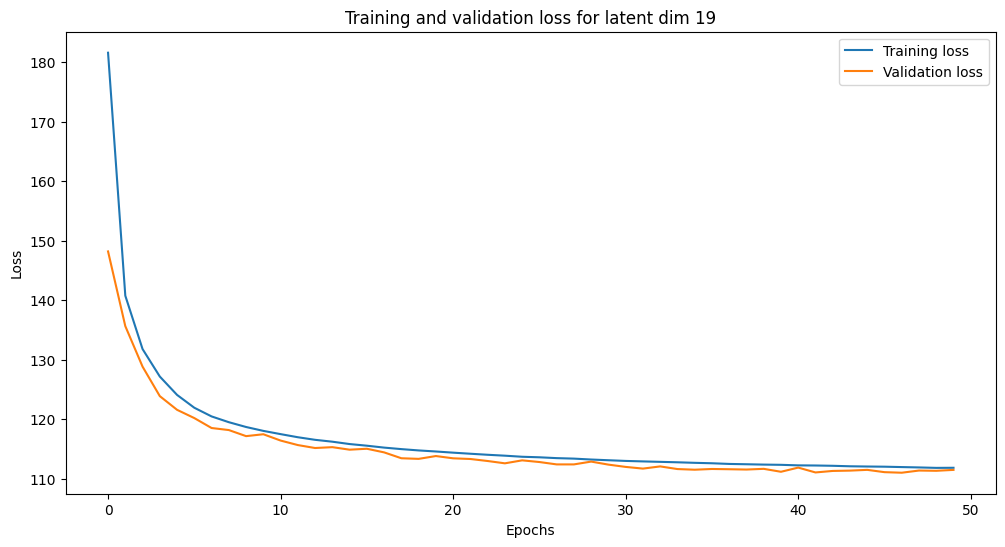

313/313 [==============================] - 1s 2ms/step


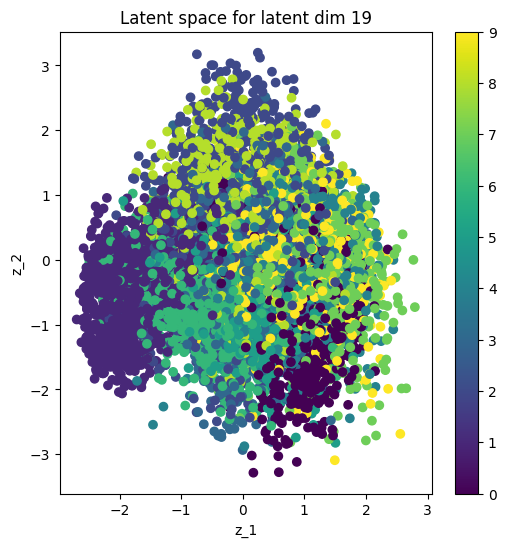

1/1 [==============================] - 0s 17ms/step


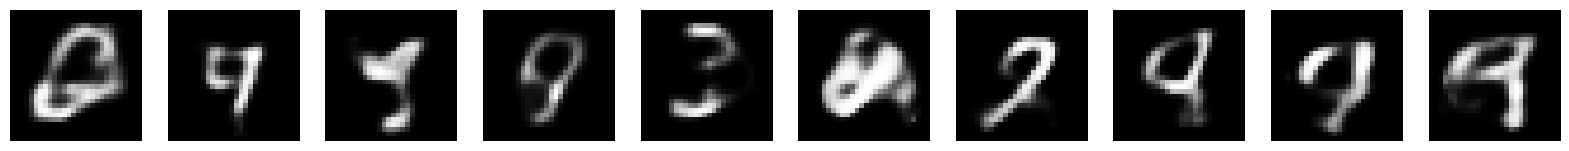

[I 2023-12-21 22:59:57,169] Trial 7 finished with value: 111.4543228149414 and parameters: {'latent_dim': 19}. Best is trial 4 with value: 111.22822570800781.


Epoch 1/50
600/600 [==============================] - 5s 7ms/step - loss: 180.6127 - val_loss: 145.2073
Epoch 2/50
600/600 [==============================] - 3s 6ms/step - loss: 139.0113 - val_loss: 132.4649
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 131.2682 - val_loss: 127.5777
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 127.5087 - val_loss: 126.2740
Epoch 5/50
600/600 [==============================] - 4s 6ms/step - loss: 125.2747 - val_loss: 123.4352
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 123.7467 - val_loss: 122.0013
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 122.5452 - val_loss: 120.6791
Epoch 8/50
600/600 [==============================] - 3s 5ms/step - loss: 121.6153 - val_loss: 120.3221
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 120.8741 - val_loss: 119.5420
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

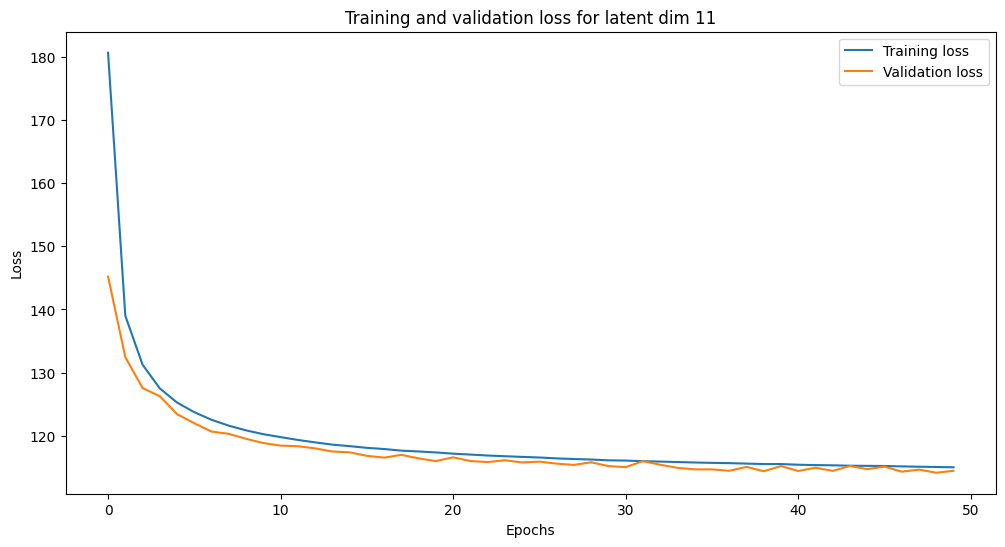

313/313 [==============================] - 1s 2ms/step


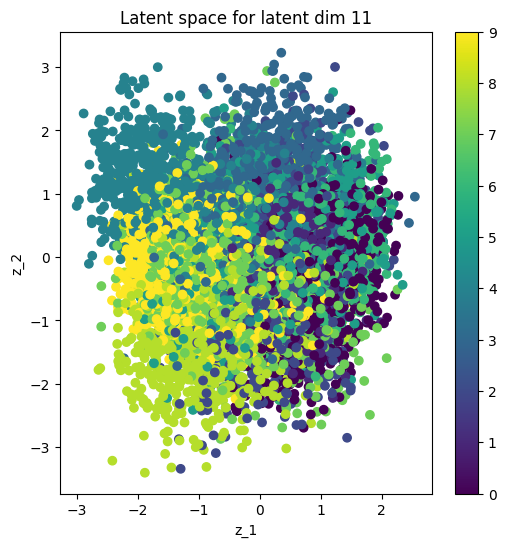

1/1 [==============================] - 0s 17ms/step


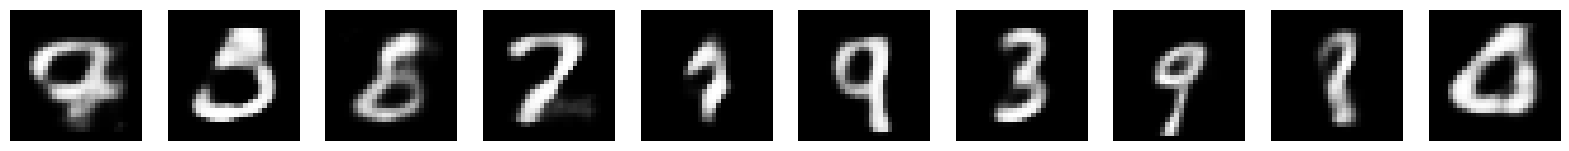

[I 2023-12-21 23:02:35,933] Trial 8 finished with value: 114.482666015625 and parameters: {'latent_dim': 11}. Best is trial 4 with value: 111.22822570800781.


Epoch 1/50
600/600 [==============================] - 4s 5ms/step - loss: 180.9190 - val_loss: 149.0005
Epoch 2/50
600/600 [==============================] - 3s 5ms/step - loss: 145.1265 - val_loss: 140.5979
Epoch 3/50
600/600 [==============================] - 3s 5ms/step - loss: 139.4766 - val_loss: 137.2160
Epoch 4/50
600/600 [==============================] - 3s 5ms/step - loss: 136.5347 - val_loss: 134.6558
Epoch 5/50
600/600 [==============================] - 3s 5ms/step - loss: 134.6073 - val_loss: 132.9738
Epoch 6/50
600/600 [==============================] - 3s 5ms/step - loss: 133.2133 - val_loss: 132.1797
Epoch 7/50
600/600 [==============================] - 3s 5ms/step - loss: 132.0912 - val_loss: 130.9490
Epoch 8/50
600/600 [==============================] - 4s 6ms/step - loss: 131.1934 - val_loss: 130.5347
Epoch 9/50
600/600 [==============================] - 3s 5ms/step - loss: 130.4601 - val_loss: 129.6217
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

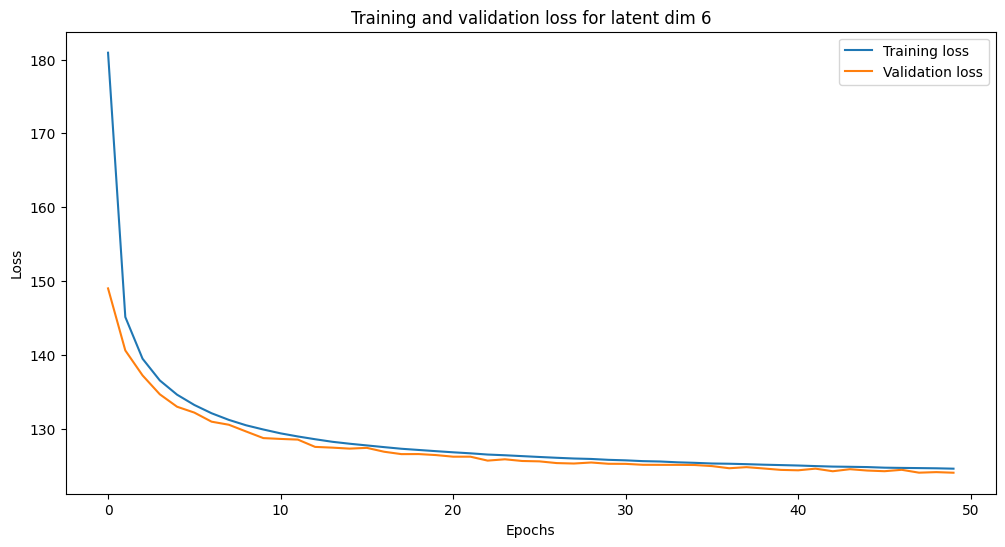

313/313 [==============================] - 1s 2ms/step


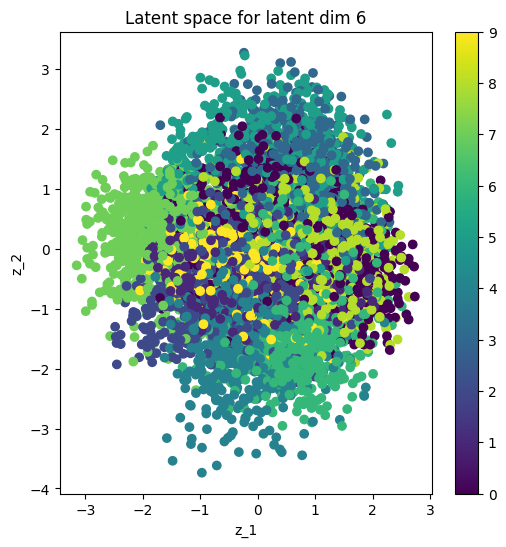

1/1 [==============================] - 0s 21ms/step


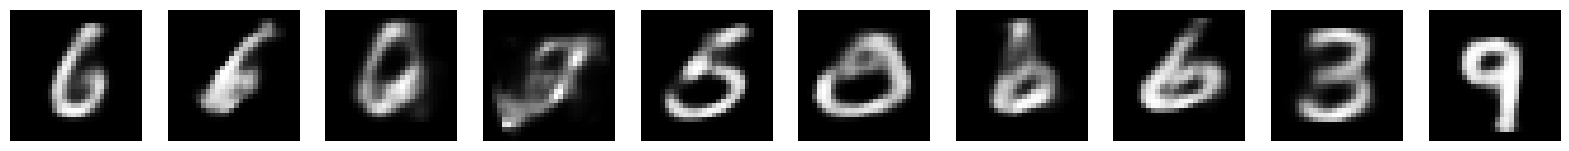

[I 2023-12-21 23:05:21,868] Trial 9 finished with value: 124.03614044189453 and parameters: {'latent_dim': 6}. Best is trial 4 with value: 111.22822570800781.


Best latent_dim: 18


In [ ]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best hyperparameter
print("Best latent_dim:", study.best_params['latent_dim'])


7. Final Output
After completing the trials, the code prints the best latent_dim found by Optuna.
The saved images in the directory provide a visual representation of the VAE's performance for each set of hyperparameters tested.
This code effectively integrates a VAE model with Optuna for hyperparameter optimization, demonstrating not only model training and evaluation but also the generation and saving of representative images, providing a comprehensive view of the model's capabilities.

Throughout the training process, we utilized Optuna hyperparameter tuning to enable the model to be trained on a variety of values for the latent_dim. After experimenting with various options, we found that the best result came from setting the dimension to 18, which proved optimal for our current situation.

As of now, the Vae image generated for the MNIST dataset has proven to be the most effective in terms of creating high-quality images with minimal noise. In contrast, the generated images in the trail with 19 dimensions were found to be more noisy than those in the 18 trail.

Overall, this demonstrates that the choice of hyperparameters can have a significant effect on the quality of the generated images. By utilizing the Optuna hyperparameter tuning method, we were able to identify the optimal dimension for our current situation, which resulted in the generation of high-quality images with minimal noise.